# Chronic Kidney Disease - Implementing a Neural Network on Keras

The original dataset can be found [here](https://www.kaggle.com/datasets/mansoordaku/ckdisease).

We use the cleaned Dataset in this notebook, which can be found in the relevant GitHub directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.activations import softmax, relu

In [2]:
data = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Machine Learning/Data Training/Chronic Kidney Disease/Chronic Kidney Disease Preprocessed.csv')
data.head()

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cells,Pus Cell Clumps,Bacteria,Blood Glucose Random,...,Packed Cell Volume,White Blood Cells,Red Blood Cells Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Chronic Kidney Disease
0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,121.0,...,44.0,7800.0,5.2,1,1,0,0,0,0,ckd
1,7.0,50.0,1.020,4.0,0.0,1,1,0,0,99.0,...,38.0,6000.0,5.2,0,0,0,0,0,0,ckd
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.0,...,31.0,7500.0,5.2,0,1,0,1,0,1,ckd
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,...,32.0,6700.0,3.9,1,0,0,1,1,1,ckd
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.0,...,35.0,7300.0,4.6,0,0,0,0,0,0,ckd


Quick check:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      400 non-null    float64
 1   Blood Pressure           400 non-null    float64
 2   Specific Gravity         400 non-null    float64
 3   Albumin                  400 non-null    float64
 4   Sugar                    400 non-null    float64
 5   Red Blood Cells          400 non-null    int64  
 6   Pus Cells                400 non-null    int64  
 7   Pus Cell Clumps          400 non-null    int64  
 8   Bacteria                 400 non-null    int64  
 9   Blood Glucose Random     400 non-null    float64
 10  Blood Urea               400 non-null    float64
 11  Serum Creatinine         400 non-null    float64
 12  Sodium                   400 non-null    float64
 13  Potassium                400 non-null    float64
 14  Hemoglobin               4

## Split the Features and Target

In [4]:
x_data = data.drop('Chronic Kidney Disease', axis = 1)
print('Shape of Features: ', x_data.shape)
y_data = data['Chronic Kidney Disease']
print('Shape of the target: ', y_data.shape)

Shape of Features:  (400, 24)
Shape of the target:  (400,)


The target class is imbalanced:

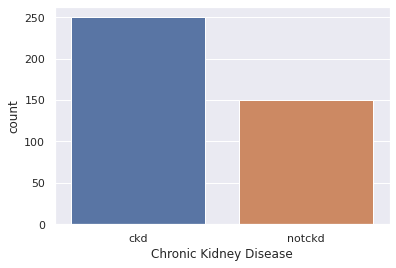

In [5]:
sns.countplot(x = y_data)

We balance the target class:

In [6]:
from imblearn.over_sampling import ADASYN
from collections import Counter
oversampler = ADASYN()
X_data, Y_data = oversampler.fit_resample(x_data, y_data)
Counter(Y_data)

Counter({'ckd': 250, 'notckd': 229})

In [7]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
robustscaler = RobustScaler()
robustscaler.fit(X_data)
X_scaled = robustscaler.transform(X_data)
Scaled_Data = pd.DataFrame(X_scaled, columns = X_data.columns)
Scaled_Data.head()

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cells,Pus Cell Clumps,Bacteria,Blood Glucose Random,...,Hemoglobin,Packed Cell Volume,White Blood Cells,Red Blood Cells Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia
0,-0.180452,0.346936,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.205128,...,0.368421,0.317196,-0.551724,0.000000,1.0,1.0,0.0,0.0,0.0,0.0
1,-1.963060,-2.653064,0.000000,4.0,0.0,0.0,0.0,0.0,0.0,-0.358974,...,-0.710526,-0.317196,-1.172414,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.428244,0.346936,-1.890246,2.0,3.0,0.0,0.0,0.0,0.0,7.948718,...,-1.157895,-1.057320,-0.655172,0.000000,0.0,1.0,0.0,1.0,0.0,1.0
3,-0.180452,-0.653064,-2.835369,4.0,0.0,0.0,-1.0,1.0,0.0,0.102564,...,-0.736842,-0.951588,-0.931034,-2.166667,1.0,0.0,0.0,1.0,1.0,1.0
4,-0.050017,0.346936,-1.890246,2.0,0.0,0.0,0.0,0.0,0.0,-0.179487,...,-0.631579,-0.634392,-0.724138,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
minmaxscaler = MinMaxScaler()
minmaxscaler.fit(Scaled_Data)
X_Scaled = minmaxscaler.transform(Scaled_Data)
Scaled_data = pd.DataFrame(X_Scaled, columns = Scaled_Data.columns)
Scaled_data.head()

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cells,Pus Cell Clumps,Bacteria,Blood Glucose Random,...,Hemoglobin,Packed Cell Volume,White Blood Cells,Red Blood Cells Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia
0,0.522727,0.230769,0.75,0.2,0.0,1.0,1.0,0.0,0.0,0.211538,...,0.836735,0.777778,0.231405,0.525424,1.0,1.0,0.0,0.0,0.0,0.0
1,0.056818,0.000000,0.75,0.8,0.0,1.0,1.0,0.0,0.0,0.164530,...,0.557823,0.644444,0.157025,0.525424,0.0,0.0,0.0,0.0,0.0,0.0
2,0.681818,0.230769,0.25,0.4,0.6,1.0,1.0,0.0,0.0,0.856838,...,0.442177,0.488889,0.219008,0.525424,0.0,1.0,0.0,1.0,0.0,1.0
3,0.522727,0.153846,0.00,0.8,0.0,1.0,0.0,1.0,0.0,0.202991,...,0.551020,0.511111,0.185950,0.305085,1.0,0.0,0.0,1.0,1.0,1.0
4,0.556818,0.230769,0.25,0.4,0.0,1.0,1.0,0.0,0.0,0.179487,...,0.578231,0.577778,0.210744,0.423729,0.0,0.0,0.0,0.0,0.0,0.0


## Principal Component Analysis

### Scree Plot - Robust Scaler

In [9]:
from sklearn.decomposition import PCA
pca_robust = PCA()
pca_robust.fit(Scaled_Data)
pca_robust.get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

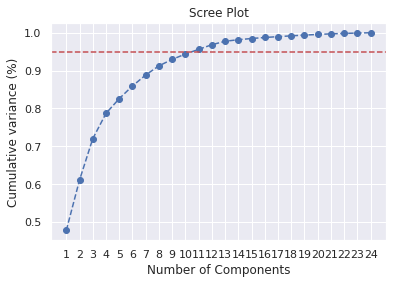

In [10]:
fig, ax = plt.subplots()
xi = np.arange(1, len(Scaled_Data.columns)+1, 1)
yi = np.cumsum(pca_robust.explained_variance_ratio_)

plt.plot(xi, yi, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(xi)
plt.ylabel('Cumulative variance (%)')
plt.title('Scree Plot')
plt.axhline(y = 0.95, color='r', linestyle='--')
ax.grid("both")
plt.show()

We require 11 components to explain 95% of the variance.

### Scree Plot - MinMax Scaler + Robust Scaler

In [11]:
pca_minmax = PCA()
pca_minmax.fit(Scaled_data)
pca_minmax.get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

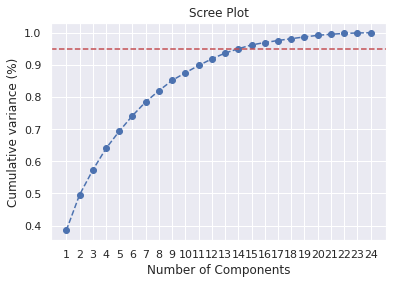

In [12]:
fig, ax = plt.subplots()
xi = np.arange(1, len(Scaled_data.columns)+1, 1)
yi = np.cumsum(pca_minmax.explained_variance_ratio_)

plt.plot(xi, yi, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(xi)
plt.ylabel('Cumulative variance (%)')
plt.title('Scree Plot')
plt.axhline(y = 0.95, color='r', linestyle='--')
ax.grid("both")
plt.show()

We need 15 components to explain 95% of the variance when we use MinMax Scaler on top of the Robust Scaler.

### PCA - Robust Scaler

In [13]:
pca_robust = PCA(n_components=0.95, random_state = 42)
pca_robust.fit(Scaled_Data)
X_PCA = pca_robust.transform(Scaled_Data)
print('Shape of X before PCA: ', Scaled_Data.shape)
print('Shape of X after PCA: ', X_PCA.shape)

Shape of X before PCA:  (479, 24)
Shape of X after PCA:  (479, 11)


In [14]:
columns_PCA = ['PCA Compponent %i' %i for i in range(1, 12)]
PCA_Data = pd.DataFrame(pca_robust.transform(X_data), columns = columns_PCA)
PCA_Data.head()

,PCA Compponent 1,PCA Compponent 2,PCA Compponent 3,PCA Compponent 4,PCA Compponent 5,PCA Compponent 6,PCA Compponent 7,PCA Compponent 8,PCA Compponent 9,PCA Compponent 10,PCA Compponent 11
0,88.559341,-767.857090,-429.307821,-165.313506,-387.854209,-68.434489,1897.815288,3639.887349,5172.324256,3591.026861,-345.885372
1,56.808727,-587.874359,-323.424964,-117.335578,-307.870964,-58.585298,1461.569939,2822.349218,3958.705908,2761.922148,-285.410816
2,116.191901,-937.087889,-472.729686,20.143593,-395.047670,-135.300503,1776.879561,3471.460165,4966.382753,3473.578371,-416.779265
3,89.162457,-675.227130,-369.204780,-146.351407,-338.174799,-74.895913,1631.063353,3115.035223,4447.270599,3086.033228,-297.247850
4,79.874692,-715.821970,-400.148507,-158.464706,-355.715967,-61.643232,1777.638261,3416.448909,4838.825538,3359.080001,-322.753634


In [15]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(Y_data)

In [16]:
X = PCA_Data.values
Y = Y_encoded

## Split into Test and Train Sets

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size = 0.2)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_train shape: ', Y_train.shape)
print('Y_test shape: ', Y_test.shape)

X_train shape:  (383, 11)
X_test shape:  (96, 11)
Y_train shape:  (383,)
Y_test shape:  (96,)


## Multilayer Perceptron Model

We would like an input layer, three 

In [18]:
from keras.models.cloning import Input
classifier = Sequential()
# classifier.add(Input(shape=(11, )))
classifier.add(Dense(15, input_shape = (X_train.shape[1],), activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(15, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(1, activation='softmax'))
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                180       
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 436
Trainable params: 436
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
6/6 [==============================] - 1s 40ms/step - loss: 1796.9626 - sparse_categorical_accuracy: 0.5248 - val_loss: 1182.6185 - val_sparse_categorical_accuracy: 0.5104
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1454.0544 - sparse_categorical_accuracy: 0.5248 - val_loss: 946.6225 - val_sparse_categorical_accuracy: 0.5104
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 1454.7336 - sparse_categorical_accuracy: 0.5248 - val_loss: 730.3382 - val_sparse_categorical_accuracy: 0.5104
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 1418.2642 - sparse_categorical_accuracy: 0.5248 - val_loss: 551.4394 - val_sparse_categorical_accuracy: 0.5104
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1125.6924 - sparse_categorical_accuracy: 0.5248 - val_loss: 415.7846 - val_sparse_categorical_accuracy: 0.5104
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1056.1042 - sparse_cat

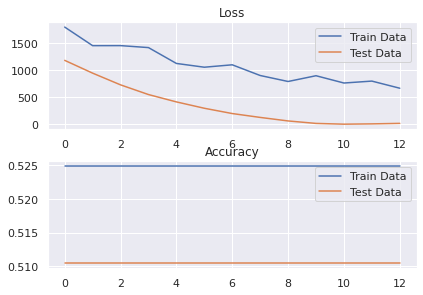

<Figure size 432x288 with 0 Axes>

In [19]:
classifier.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics='sparse_categorical_accuracy')
history = classifier.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size = 64, 
               callbacks = EarlyStopping(patience = 2), verbose = 1, epochs = 50)

# Training Loss
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='Train Data')
plt.plot(history.history['val_loss'], label='Test Data')
plt.legend()
plt.tight_layout()

# Training Accuracy
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Data')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Test Data')
plt.legend()
plt.show()
plt.tight_layout()

### Performance Evaluation

In [20]:
train_loss, train_accuracy = classifier.evaluate(X_train, Y_train, verbose=0)
test_loss, test_accuracy = classifier.evaluate(X_test, Y_test, verbose=0)
print('Train accuracy: %.2f%%, Test accuracy: %.2f%%' % (train_accuracy*100, test_accuracy*100))

Train accuracy: 52.48%, Test accuracy: 51.04%


### Precision-Recall Curve

In [21]:
predictions = classifier.predict(X_test, verbose = True)
print("Shape of Predictions:", predictions.shape)

3/3 [==============================] - 0s 3ms/step
Shape of Predictions: (96, 1)


3/3 [==============================] - 0s 4ms/step


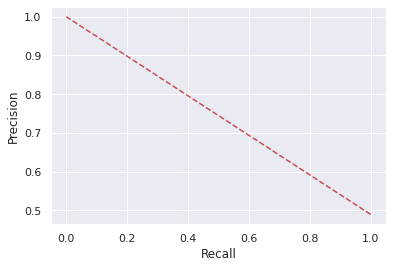

In [22]:
from sklearn.metrics import precision_recall_curve
plt.subplots()
precision, recall, thresholds = precision_recall_curve(Y_test, classifier.predict(X_test))
plt.plot(recall, precision, 'r--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Looks like it is a good model - not good or not bad at all. 

There is a linear relationship between the Precision and Recall. Perhaps we can use validation to generalize the Precision-Recall Curve.